# Pvalue Precision  

We found that too many zero pvalues in our data:

This is plink results for URIC:
```console
┌────────┬───────────┬─────────────┬─────┬───┬───────────┬───────────┬─────────────┬─────────┐
│ #CHROM ┆ POS       ┆ ID          ┆ REF ┆ … ┆ SE        ┆ T_STAT    ┆ P           ┆ ERRCODE │
│ ---    ┆ ---       ┆ ---         ┆ --- ┆   ┆ ---       ┆ ---       ┆ ---         ┆ ---     │
│ i64    ┆ i64       ┆ str         ┆ str ┆   ┆ f64       ┆ f64       ┆ f64         ┆ str     │
╞════════╪═══════════╪═════════════╪═════╪═══╪═══════════╪═══════════╪═════════════╪═════════╡
│ 4      ┆ 9993558   ┆ rs3775948   ┆ C   ┆ … ┆ 0.007588  ┆ -34.3672  ┆ 1.2769e-256 ┆ .       │
│ 4      ┆ 10000237  ┆ rs1014290   ┆ A   ┆ … ┆ 0.007618  ┆ -33.7892  ┆ 3.2929e-248 ┆ .       │
│ 4      ┆ 88133515  ┆ rs4148155   ┆ A   ┆ … ┆ 0.008063  ┆ 30.8707   ┆ 8.1597e-208 ┆ .       │
│ 4      ┆ 88131171  ┆ rs2231142   ┆ G   ┆ … ┆ 0.0080683 ┆ 30.8671   ┆ 9.0977e-208 ┆ .       │
```
location is in `/volume/gwasfl/TWB2_240418/DATA/URIC/agg/agg.qc.PHENO1.glm.linear`




However, this is rafael's result:
```console
┌─────────────┬─────┬───────────────────┬───────────┬───┬───────┬────────────┬───────────┬──────────┐
│ rsID        ┆ CHR ┆ ID                ┆ POS       ┆ … ┆ CNT   ┆ BETA       ┆ T_STAT    ┆ P        │
│ ---         ┆ --- ┆ ---               ┆ ---       ┆   ┆ ---   ┆ ---        ┆ ---       ┆ ---      │
│ str         ┆ i64 ┆ str               ┆ i64       ┆   ┆ i64   ┆ f64        ┆ f64       ┆ f64      │
╞═════════════╪═════╪═══════════════════╪═══════════╪═══╪═══════╪════════════╪═══════════╪══════════╡
│ rs11264341  ┆ 1   ┆ 1:155179017:C:T   ┆ 155179017 ┆ … ┆ 67900 ┆ 0.070294   ┆ 8.467778  ┆ 0.0      │
│ rs4971100   ┆ 1   ┆ 1:155183255:A:G   ┆ 155183255 ┆ … ┆ 67734 ┆ -0.080764  ┆ -9.358976 ┆ 0.0      │
│ rs4072037   ┆ 1   ┆ 1:155192276:C:T   ┆ 155192276 ┆ … ┆ 67894 ┆ 0.076272   ┆ 8.451538  ┆ 0.0      │
│ rs760077    ┆ 1   ┆ 1:155208991:A:T   ┆ 155208991 ┆ … ┆ 67910 ┆ 0.076389   ┆ 8.332301  ┆ 0.0      │
```
location is in `/volume/gwasfl/TWB2_240418/RESULT/URIC/I/split0_rafael/res/gwas.glm`

As a result, the manhattan plot is terrible in rafael. The smallest pvalue is only at 1e-7 scale, the plink counterpart is 1e-156, however. It seems that there is some precision problem. We may need to use **float64** at least in pvalue calculation. 

There may be three parts to check:
1. pvalue calculation (scipy)
2. save to file (pandas)
3. send and receive (json)

Manhattan plot should be good, since plink and rafael are both plot by the same [code](https://gitlab.corp.ailabs.tw/prs/rafael/-/blob/main/rafael/plot_gwas/plot.py?ref_type=heads).

## pvalue calculation

We found that scipy cdf is hard-coded to use float64 as the following line found in many places:
```python
dtyp = np.promote_types(x.dtype, np.float64)
```

So we may not need to convert data to **float64** beforehand if we want only the pvalue calculation to be **float64** and keep other step intact for memory efficiency.


### Linear regression

As the scipy mention [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html): 

> **sf(x, loc=0, scale=1)**: Survival function (also defined as 1 - cdf, but sf is sometimes more accurate).

問Gemini 理由如下:

> sf and Subtraction: The sf function is the complement of the cdf (i.e., sf(x) = 1 - cdf(x)). Because it involves subtraction from 1, the rounding errors in cdf become less impactful. Subtracting a small number from 1 (which is much larger) has a smaller relative error compared to adding small numbers together.

We can use **sf** for numerical stability.


In [1]:
import numpy as np
from scipy import stats

def t_dist_pvalue_cdf(t_stat, df):
    return 2.0 * (1.0 - stats.t.cdf(np.abs(t_stat), df))

def t_dist_pvalue_sf(t_stat, df):
    return 2.0 * stats.t.sf(np.abs(t_stat), df)

stat = 1.4e4
pvalue = t_dist_pvalue_cdf(stat, 4)
print(f"cdf: {pvalue}")

pvalue = t_dist_pvalue_sf(stat, 4)
print(f"sf : {pvalue}")

stat = 1e60
pvalue = t_dist_pvalue_cdf(stat, 4)
print(f"cdf: {pvalue}")

pvalue = t_dist_pvalue_sf(stat, 4)
print(f"sf : {pvalue}")


cdf: 2.220446049250313e-16
sf : 1.5618491763635903e-16
cdf: 0.0
sf : 6.0000000000001e-240


### logistic regression 

Essentially same as linear one, but here we also test jax.

In [18]:
import jax
from jax import scipy as jsp
from jax import numpy as jnp
from jax import jit, vmap

jax.config.update("jax_enable_x64", True)

def chi2_dist_pvalue_cdf_jax(t_stat):
    p_value = 1.0 - jsp.stats.chi2.cdf(jnp.square(t_stat), 1)
    return p_value

def chi2_dist_pvalue_sf_jax(t_stat):
    p_value = jsp.stats.chi2.sf(jnp.square(t_stat), 1)
    return p_value

def chi2_dist_pvalue_sf(t_stat):
    p_value = stats.chi2.sf(np.square(t_stat), 1)
    return p_value

stat = 35
pvalue = chi2_dist_pvalue_cdf_jax(stat)
print(f"cdf: {pvalue}")

pvalue = chi2_dist_pvalue_sf_jax(stat)
print(f"sf(jax): {pvalue}")

pvalue = chi2_dist_pvalue_sf(stat)
print(f"sf : {pvalue}")


cdf: 0.0
sf(jax): 2.249821412945044e-268
sf : 2.249821412945044e-268


As a result, jax with `jax_enable_x64` flag is also supported for small pvalue. 

Below is the sanity check for logistic in [gwasprs](https://gitlab.corp.ailabs.tw/prs/fed-algo) package. We avoid using `jax_enable_x64` since it is set globally.

In [20]:
# new
@jit
def _cal_square_tstat(beta, inv_hessian):
    std = jnp.sqrt(inv_hessian.diagonal())
    t_stat = beta / std
    square_t_stat = jnp.square(t_stat)
    return t_stat, square_t_stat


def chi2_dist_pvalue(square_t_stat, df=1):
    p_value = stats.chi2.sf(np.array(square_t_stat), df)
    return p_value

def batched_logistic_stats(beta, inv_hessian):
    t_stat, square_t_stat = vmap(_cal_square_tstat, (0, 0), (0, 0))(beta, inv_hessian)
    p_value = chi2_dist_pvalue(square_t_stat)
    return t_stat, p_value

# old
@jit
def logistic_stats_old(beta, inv_hessian):
    std = jnp.sqrt(inv_hessian.diagonal())
    t_stat = beta / std
    p_value = 1 - jsp.stats.chi2.cdf(jnp.square(t_stat), 1)
    return t_stat, p_value


@jit
def batched_logistic_stats_old(beta, inv_hessian):
    return vmap(logistic_stats_old, (0, 0), (0, 0))(beta, inv_hessian)


beta = np.random.uniform(size=(10, 3))
inv_hessian = np.random.uniform(size=(10, 3, 3))
t_stat0, p_value0 = batched_logistic_stats_old(beta, inv_hessian)
t_stat1, p_value1 = batched_logistic_stats(beta, inv_hessian)
print(np.allclose(t_stat0, t_stat1))
print(np.allclose(p_value0, p_value1))


True
True


BTW, we also test float128 on jax, which is not yet supported.


## save to file

After getting the small pvalue above, we should store it in pandas and save to file. Here, it is important to make sure if the precision retained. The related function is in [rafael](https://gitlab.corp.ailabs.tw/prs/rafael/-/blob/main/rafael/usecases.py?ref_type=heads#L3253). 



In [5]:
import pandas as pd

def regression_results(t_stat, pval, save_path):
    glm = pd.DataFrame({"snp": [f"snp{i}" for i in range(len(t_stat))]})
    glm["P"] = pval
    glm["T_STAT"] = t_stat
    glm.to_csv(save_path, index=False, sep="\t")
    return glm

pvalues = np.array([0.05, 1e-6, 1e-10, 1e-16, 1e-200])
t_stat = np.array([1.2, 2.0, 3.1e-1, 5.4, -110000.0])
save_path = "/tmp/my_tmp_glm.tsv"
glm = regression_results(t_stat, pvalues, save_path)

! cat /tmp/my_tmp_glm.tsv

snp	P	T_STAT
snp0	0.05	1.2
snp1	1e-06	2.0
snp2	1e-10	0.31
snp3	1e-16	5.4
snp4	1e-200	-110000.0


Looks great !


## send and receive

下一個問題就是，這個 function 是在 clients , pvalue 應該是在 server 算的，也就是說這個 pvalue 需要被傳遞，之前在傳遞的過程似乎會被 clip to 1e-7，所以這個還要討論一下。這邊是由 rafael 的 [這邊](https://gitlab.corp.ailabs.tw/prs/rafael/-/blob/main/rafael/datamodel.py?ref_type=heads#L33) 負責


In [18]:
import sys 

sys.path.append("/yilun/CODE/rafael")

from rafael.datamodel import send_model
from rafael.network import base as net

X = np.array([0.05, 1e-6, 1e-10, 1e-16, 1e-17, 1e-200]).reshape(2,3)
print(X.tolist())

data = send_model(X=('NPArray', X))
request = net.construct_rpc_request("test", data)
print(request)

#response = recv_model(**response.model_dump())


{'api': 'test', 'args': AbcResponse(spec={'X': 'NPArray'}, X=array([[5.e-002, 1.e-006, 1.e-010],
       [1.e-016, 1.e-017, 1.e-200]]))}
[[0.05, 1e-06, 1e-10], [1e-16, 1e-17, 1e-200]]


Looks good!

## Result

我用 rafael 跑 URIC `/volume/gwasfl/TWB2_240418/DATA/GOUT/I/`  with **FullQuantGWAS**. 並使用修改過 local 的 gwasprs 做測試 (跑了 10000s 左右)

```bash
cp -r /yilun/CODE/fed-algo . 
poetry add tqdm 
poetry add ./fed-algo 

python3 /yilun/CODE/rafael/examples/twb2/script/cmp_glm.py \
    -i1 /volume/gwasfl/TWB2_240418/DATA/URIC/agg/agg.qc.pca.PHENO1.glm.linear \
    -n1 "plink2" \
    -i2 /volume/gwasfl/TWB2_240418/RESULT/URIC/I/split0_rafael/res3/gwas.glm \
    -n2 "rafael" \
    -o ""
```

結果如下，有符預期。

```console
┌─────────────┬─────┬──────────────────┬───────────┬───┬───────┬───────────┬────────────┬─────────────┐
│ rsID        ┆ CHR ┆ ID               ┆ POS       ┆ … ┆ CNT   ┆ BETA      ┆ T_STAT     ┆ P           │
│ ---         ┆ --- ┆ ---              ┆ ---       ┆   ┆ ---   ┆ ---       ┆ ---        ┆ ---         │
│ str         ┆ i64 ┆ str              ┆ i64       ┆   ┆ i64   ┆ f64       ┆ f64        ┆ f64         │
╞═════════════╪═════╪══════════════════╪═══════════╪═══╪═══════╪═══════════╪════════════╪═════════════╡
│ rs3775948   ┆ 4   ┆ 4:9993558:C:G    ┆ 9993558   ┆ … ┆ 67730 ┆ 0.260579  ┆ 34.352968  ┆ 2.0684e-256 │
│ rs1014290   ┆ 4   ┆ 4:10000237:A:G   ┆ 10000237  ┆ … ┆ 67912 ┆ 0.257032  ┆ 33.75717   ┆ 9.5728e-248 │
│ rs4148155   ┆ 4   ┆ 4:88133515:A:G   ┆ 88133515  ┆ … ┆ 67929 ┆ -0.246982 ┆ -30.647656 ┆ 7.1425e-205 │
│ rs2231142   ┆ 4   ┆ 4:88131171:G:T   ┆ 88131171  ┆ … ┆ 67955 ┆ -0.247125 ┆ -30.643812 ┆ 8.0137e-205 │

Union: 160
Intersect: 160
cor: 0.999659262652695
ji: 1.0
```



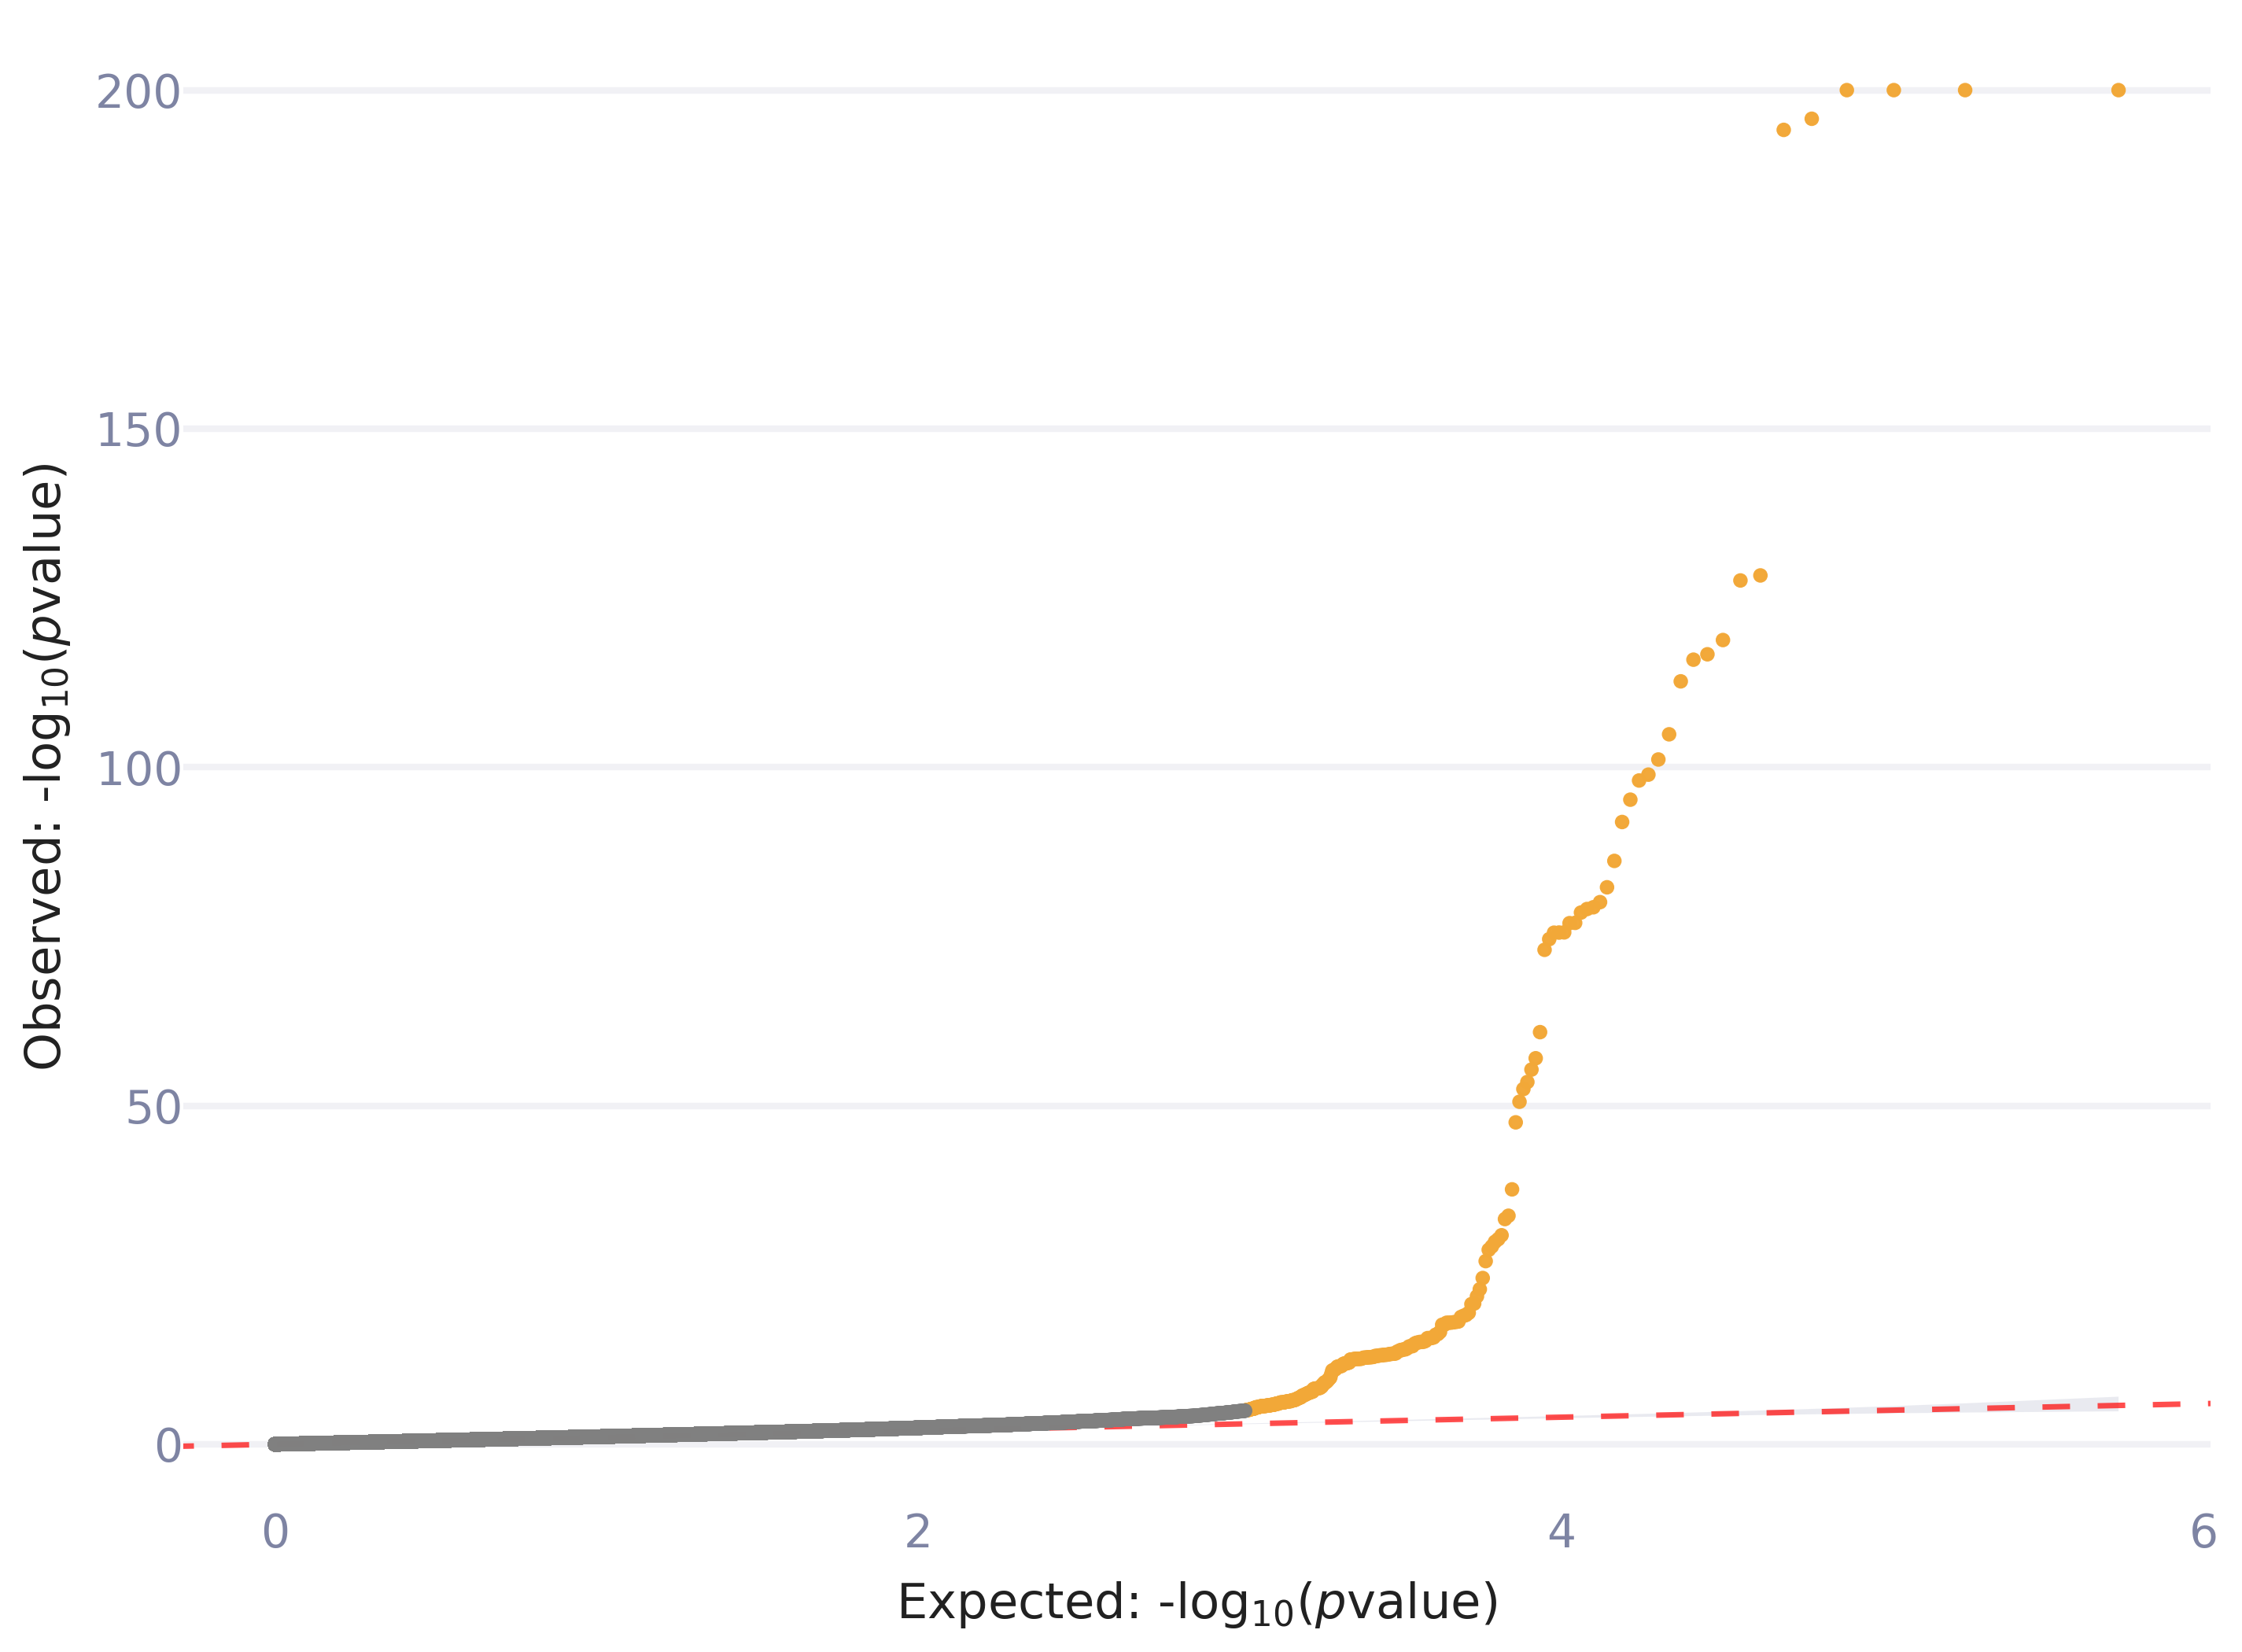

In [2]:
from IPython.display import Image
Image(filename='images/gwas.qq.png')


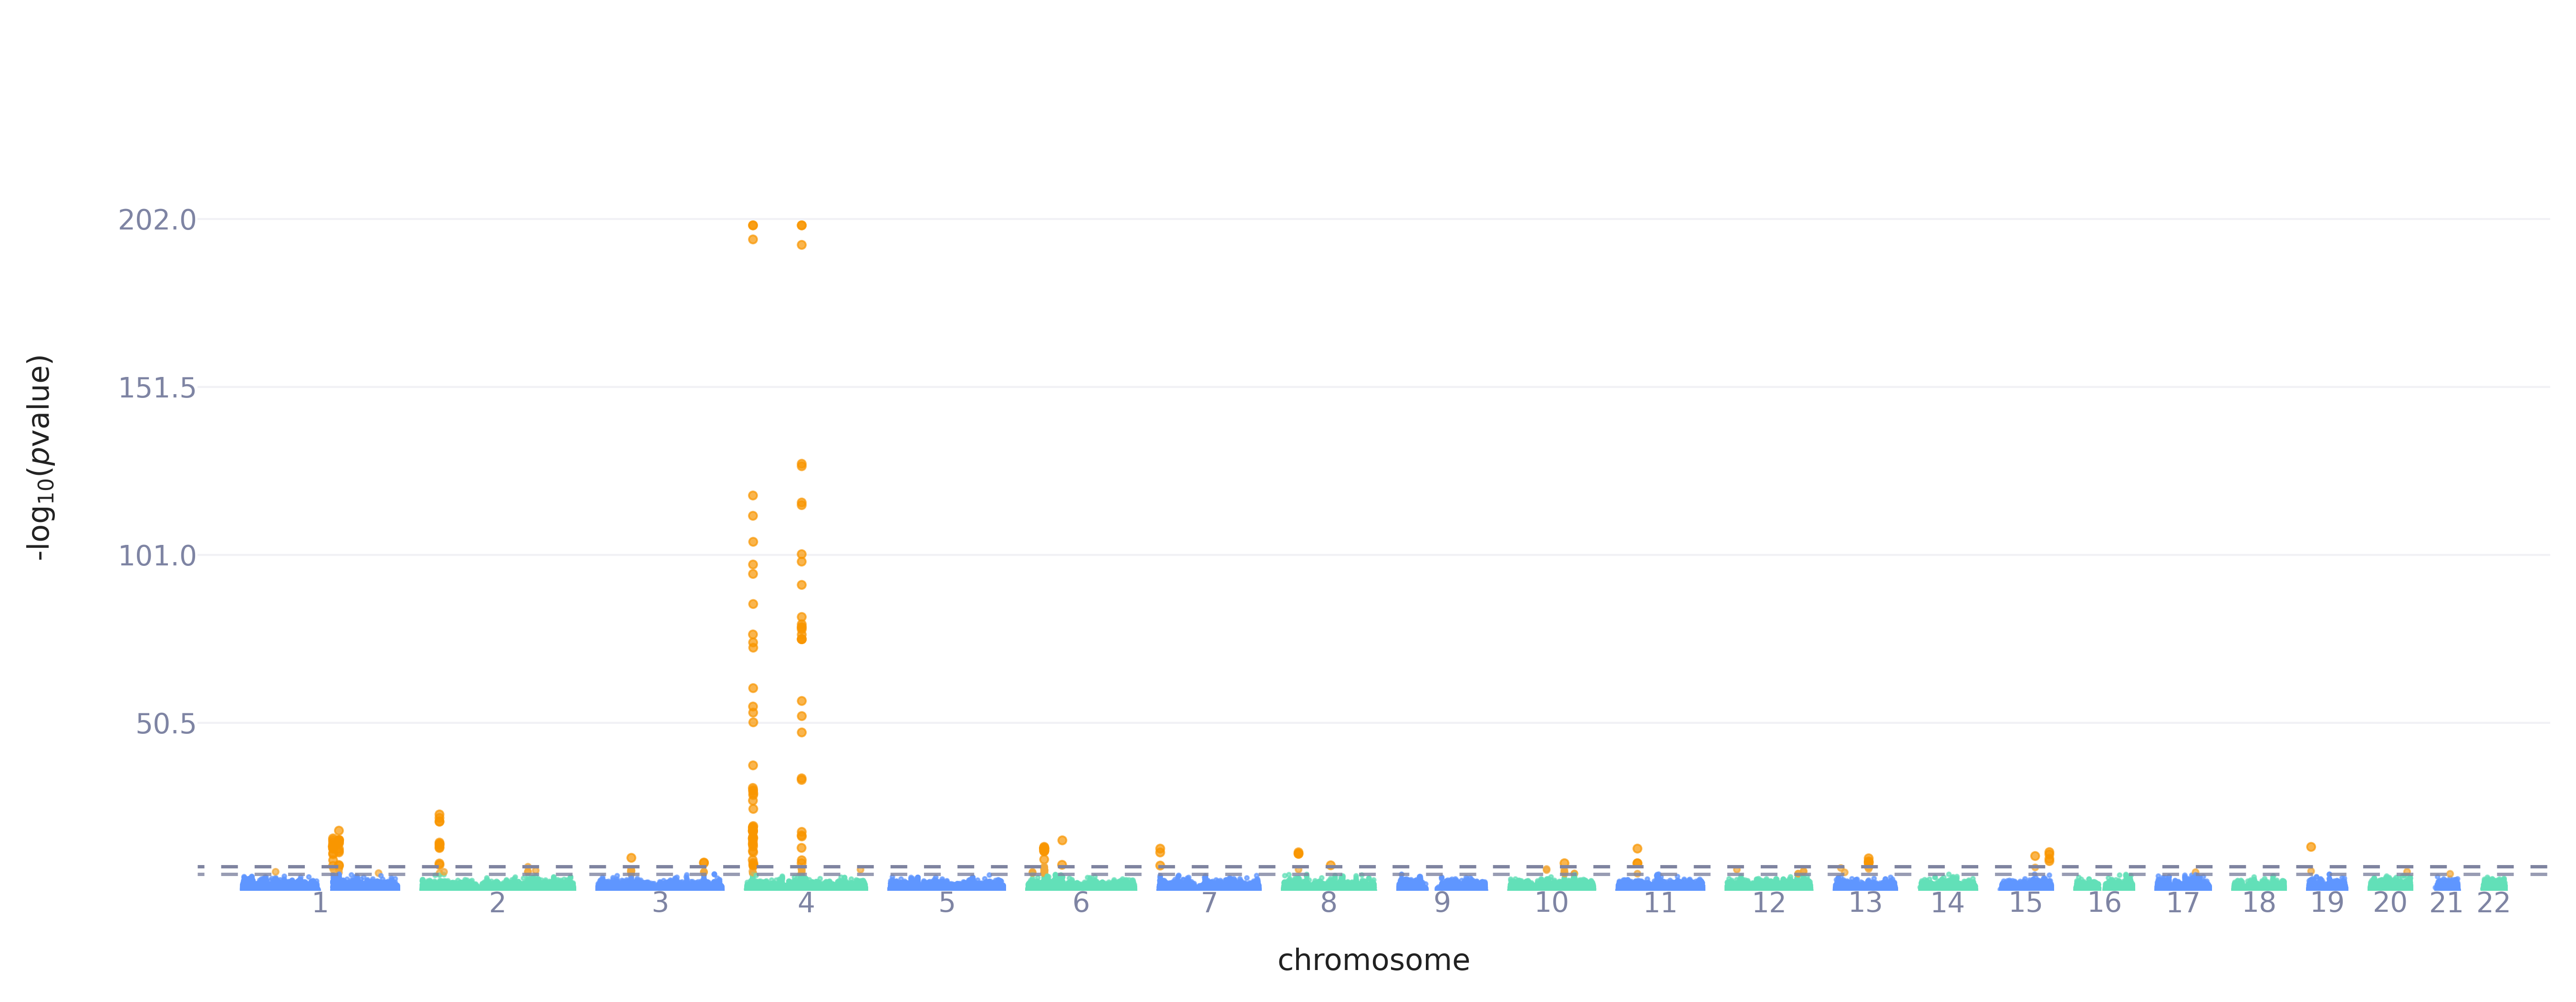

In [3]:
from IPython.display import Image
Image(filename='images/gwas.manhattan.png')
